# Maritime Terminal and Shipping Lane Discovery

This notebook runs the complete maritime lane and terminal discovery pipeline using our existing scripts, configuration files, and source code.

## Overview
- **Input**: Raw AIS data files
- **Processing**: Vessel trajectories → H3 sequences → Terminal clustering → Route analysis
- **Output**: Maritime terminals, shipping lanes, and interactive visualizations

## Configuration
We'll use the `global_maritime_discovery.yaml` configuration file with our proven scripts and source code modules.

In [1]:
import sys
import yaml
import pandas as pd
import numpy as np
import time
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

print("🌊 Maritime Terminal and Shipping Lane Discovery")
print(f"📁 Project root: {project_root}")
print(f"⏰ Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Load configuration
config_path = project_root / "config" / "global_maritime_discovery.yaml"
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print(f"✅ Configuration loaded from: {config_path}")
print(f"🎯 Analysis: {config['global_discovery']['name']}")
print(f"📋 Version: {config['global_discovery']['version']}")

# Create output directory
output_dir = project_root / config['outputs']['base_directory']
output_dir.mkdir(exist_ok=True, parents=True)
print(f"📂 Output directory: {output_dir}")

# Import our modules - using the actual structure from your codebase
from src.data.loader import AISDataLoader
from src.features.trajectory_processor import extract_vessel_trajectories
from src.features.terminal_discovery import TerminalDiscovery  
from src.features.route_clustering import cluster_shipping_routes

print("✅ All modules imported successfully")

🌊 Maritime Terminal and Shipping Lane Discovery
📁 Project root: /home/marius/repo_linux/ais-forecasting
⏰ Start time: 2025-08-01 23:37:19
✅ Configuration loaded from: /home/marius/repo_linux/ais-forecasting/config/global_maritime_discovery.yaml
🎯 Analysis: Global Maritime Terminal Discovery
📋 Version: 1.0.0
📂 Output directory: /home/marius/repo_linux/ais-forecasting/data/processed
✅ All modules imported successfully
✅ All modules imported successfully


## 1. Load AIS Data

Loading AIS data using our existing data loader with the years specified in the configuration.

In [2]:
# Initialize data loader
data_dir = project_root / "data"
loader = AISDataLoader(str(data_dir), use_duckdb=False)

print("🔄 Loading AIS data...")
start_time = time.time()

# Load data for the years specified in config
years = ["2024"]  # Start with 2024 data for testing
ais_data = loader.load_multi_year_data_original(years)

# Apply memory and vessel limits from config
max_vessels = config['processing']['max_vessels_per_batch']
unique_vessels = ais_data['imo'].unique()

if len(unique_vessels) > max_vessels:
    print(f"⚡ Limiting to {max_vessels} vessels for processing")
    selected_vessels = unique_vessels[:max_vessels]
    ais_data = ais_data[ais_data['imo'].isin(selected_vessels)]

load_time = time.time() - start_time

print(f"✅ Data loaded in {load_time:.1f} seconds")
print(f"📊 Records: {len(ais_data):,}")
print(f"🚢 Vessels: {ais_data['imo'].nunique():,}")
print(f"📅 Date range: {ais_data['mdt'].min()} to {ais_data['mdt'].max()}")
print(f"🌍 Geographic coverage:")
print(f"   Latitude: {ais_data['lat'].min():.2f}° to {ais_data['lat'].max():.2f}°")
print(f"   Longitude: {ais_data['lon'].min():.2f}° to {ais_data['lon'].max():.2f}°")

# Display sample data
print(f"\n📋 Sample data:")
print(ais_data.head())

🔄 Loading AIS data...
⚡ Limiting to 1000 vessels for processing
⚡ Limiting to 1000 vessels for processing
✅ Data loaded in 8.0 seconds
📊 Records: 8,058,676
🚢 Vessels: 1,000
📅 Date range: 2024-01-01 00:00:00+00:00 to 2024-12-31 00:00:00+00:00
🌍 Geographic coverage:
   Latitude: -66.45° to 78.34°
   Longitude: -180.00° to 180.00°

📋 Sample data:
       imo  lat1   lon1  draught  speed                       mdt  \
0  9271597  37.0  123.5     19.0   10.6 2024-12-30 23:00:26+00:00   
1  9271597  36.8  123.6     19.0   10.5 2024-12-30 22:00:09+00:00   
2  9271597  36.7  123.7     19.0   10.2 2024-12-30 21:05:21+00:00   
3  9271597  36.5  123.7     19.0   10.1 2024-12-30 20:04:22+00:00   
4  9271597  36.3  123.7     19.0   10.0 2024-12-30 19:04:02+00:00   

                   next_mdt destination destination_raw  \
0 2024-12-31 00:00:11+00:00      yantai      YAN TAI,CN   
1 2024-12-30 23:00:26+00:00      yantai      YAN TAI,CN   
2 2024-12-30 22:00:09+00:00      yantai      YAN TAI,CN   
3 2

## 2. Extract Vessel Trajectories

Processing vessel movements into H3-indexed trajectories with journey segmentation.

In [3]:
print("🔄 Extracting vessel trajectories...")
trajectory_start = time.time()

# Configure trajectory processing from config file
trajectory_config = {
    'h3_resolution': config['processing']['h3_resolution'],
    'min_journey_length': config['processing']['min_journey_length'],
    'max_journey_length': config['processing']['max_journey_length'],
    'speed_threshold_knots': config['processing']['speed_threshold_knots'],
    'time_gap_hours': config['processing']['time_gap_hours']
}

print(f"📋 Trajectory configuration:")
for key, value in trajectory_config.items():
    print(f"   {key}: {value}")

# Extract trajectories using our proven trajectory processor
trajectories = extract_vessel_trajectories(ais_data, trajectory_config)

trajectory_time = time.time() - trajectory_start

if not trajectories.empty:
    print(f"✅ Trajectory extraction complete in {trajectory_time:.1f} seconds")
    print(f"📊 Trajectory summary:")
    print(f"   Total trajectories: {len(trajectories):,}")
    print(f"   Unique vessels: {trajectories['vessel_id'].nunique():,}")
    print(f"   Average duration: {trajectories['duration_hours'].mean():.1f} hours")
    print(f"   Average H3 cells per trajectory: {trajectories['unique_h3_cells'].mean():.1f}")
    print(f"   Longest trajectory: {trajectories['duration_hours'].max():.1f} hours")
    
    # Save trajectories
    trajectory_output = output_dir / "vessel_trajectories.parquet"
    trajectories.to_parquet(trajectory_output, index=False)
    print(f"💾 Trajectories saved to: {trajectory_output}")
    
    # Show sample trajectories
    print(f"\n📋 Sample trajectories:")
    display(trajectories.head())
    
else:
    print("❌ No trajectories extracted")
    trajectories = pd.DataFrame()

🔄 Extracting vessel trajectories...
📋 Trajectory configuration:
   h3_resolution: 5
   min_journey_length: 5
   max_journey_length: 1000
   speed_threshold_knots: 0.5
   time_gap_hours: 6
✅ Trajectory extraction complete in 81.9 seconds
📊 Trajectory summary:
   Total trajectories: 7,769
   Unique vessels: 992
   Average duration: 1069.7 hours
   Average H3 cells per trajectory: 548.6
   Longest trajectory: 8760.0 hours
✅ Trajectory extraction complete in 81.9 seconds
📊 Trajectory summary:
   Total trajectories: 7,769
   Unique vessels: 992
   Average duration: 1069.7 hours
   Average H3 cells per trajectory: 548.6
   Longest trajectory: 8760.0 hours
💾 Trajectories saved to: /home/marius/repo_linux/ais-forecasting/data/processed/vessel_trajectories.parquet

📋 Sample trajectories:
💾 Trajectories saved to: /home/marius/repo_linux/ais-forecasting/data/processed/vessel_trajectories.parquet

📋 Sample trajectories:


,vessel_id,trajectory_id,start_time,end_time,duration_hours,point_count,unique_h3_cells,avg_speed,max_speed,stationary_points,h3_sequence,start_lat,start_lon,end_lat,end_lon
0,9271597,9271597_0,2024-01-01 00:00:41+00:00,2024-01-09 11:11:33+00:00,203.181111,200,97,6.260000,14.6,100,"[85301157fffffff, 85301157fffffff, 85301157fff...",37.583344,121.384730,19.243570,117.356710
1,9271597,9271597_200,2024-01-09 19:39:22+00:00,2024-04-04 04:22:09+00:00,2048.713056,2022,1432,9.487685,16.9,405,"[85412463fffffff, 85412477fffffff, 8541242bfff...",17.728743,116.312900,0.955003,108.196660
2,9271597,9271597_2222,2024-04-04 11:03:51+00:00,2024-04-12 06:03:51+00:00,187.000000,182,176,10.845604,12.5,0,"[8569922ffffffff, 856993d3fffffff, 8569906ffff...",2.222120,108.248160,31.847510,123.932910
3,9271597,9271597_2404,2024-04-12 12:15:55+00:00,2024-07-27 20:10:03+00:00,2551.902222,2522,1775,8.419270,15.8,592,"[85308b37fffffff, 85308b37fffffff, 85308ba7fff...",32.842280,123.899270,8.536275,111.142494
4,9271597,9271597_4926,2024-07-28 02:14:33+00:00,2024-09-01 23:00:07+00:00,860.759444,854,207,2.672600,13.9,635,"[8569adcffffffff, 8569ad13fffffff, 8569ad13fff...",9.428204,111.639465,35.999037,120.276367


## 3. Discover Maritime Terminals

Identifying ports, anchorages, and other maritime terminals from stationary vessel patterns.

In [ ]:
if not trajectories.empty:
    print("🔄 Discovering maritime terminals...")
    terminal_start = time.time()
    
    # Extract terminal candidates from trajectory endpoints and stationary periods
    print("📍 Extracting terminal candidates...")
    
    # Get trajectory start and end points as potential terminals
    terminal_points = []
    
    for _, traj in trajectories.iterrows():
        # Start point
        terminal_points.append({
            'imo': traj['vessel_id'],  # Use imo column name as expected by TerminalDiscovery
            'mdt': traj['start_time'],
            'lat': traj['start_lat'],
            'lon': traj['start_lon'],
            'speed': 0.0,  # Endpoints are considered stationary
            'point_type': 'trajectory_start'
        })
        
        # End point
        terminal_points.append({
            'imo': traj['vessel_id'],
            'mdt': traj['end_time'],
            'lat': traj['end_lat'],
            'lon': traj['end_lon'],
            'speed': 0.0,
            'point_type': 'trajectory_end'
        })
    
    terminal_candidates = pd.DataFrame(terminal_points)
    print(f"✅ Extracted {len(terminal_candidates):,} terminal candidates")
    
    # Configure terminal discovery using the correct config file structure
    terminal_config = {
        'stationary_speed_threshold': config['processing']['speed_threshold_knots'],
        'min_stationary_duration_hours': config['terminals']['validation']['min_dwell_time_hours'],
        'terminal_proximity_km': config['terminals']['clustering']['eps_km'],
        'min_vessels_for_terminal': config['terminals']['min_vessels'],
        'h3_resolution': config['processing']['h3_resolution']
    }
    
    # Initialize terminal discovery with config
    terminal_discovery = TerminalDiscovery(terminal_config)
    
    # Discover terminals using the actual method
    print("🎯 Discovering terminals from vessel patterns...")
    discovered_terminals = terminal_discovery.discover_terminals(terminal_candidates)
    
    terminal_time = time.time() - terminal_start
    
    if not discovered_terminals.empty:
        print(f"✅ Terminal discovery complete in {terminal_time:.1f} seconds")
        print(f"📊 Terminal summary:")
        print(f"   Terminals discovered: {len(discovered_terminals)}")
        
        # Check if the expected columns exist and adapt accordingly
        if 'total_visits' in discovered_terminals.columns:
            print(f"   Average visits per terminal: {discovered_terminals['total_visits'].mean():.1f}")
            print(f"   Busiest terminal: {discovered_terminals['total_visits'].max()} visits")
            
            # Save terminals
            terminal_output = config['terminals']['output_path']
            terminal_output_path = project_root / terminal_output
            terminal_output_path.parent.mkdir(exist_ok=True, parents=True)
            
            # Convert to GeoDataFrame and save
            import geopandas as gpd
            from shapely.geometry import Point
            
            geometry = [Point(lon, lat) for lat, lon in zip(discovered_terminals['lat'], discovered_terminals['lon'])]
            terminals_gdf = gpd.GeoDataFrame(discovered_terminals, geometry=geometry, crs='EPSG:4326')
            terminals_gdf.to_file(terminal_output_path)
            
            print(f"💾 Terminals saved to: {terminal_output_path}")
            
            # Display top terminals if the columns exist
            if 'total_visits' in discovered_terminals.columns:
                print(f"\n🏆 Top 10 Terminals:")
                top_terminals = discovered_terminals.nlargest(10, 'total_visits')
                for idx, terminal in top_terminals.iterrows():
                    visits = terminal.get('total_visits', 'N/A')
                    vessels = terminal.get('unique_vessels', 'N/A')
                    print(f"   #{idx+1}: {visits} visits, {vessels} vessels at ({terminal['lat']:.3f}, {terminal['lon']:.3f})")
            
            valid_terminals = discovered_terminals
        else:
            # Handle case where column names might be different
            print(f"   Terminal characteristics available: {list(discovered_terminals.columns)}")
            valid_terminals = discovered_terminals
            
    else:
        print("❌ No terminals discovered")
        valid_terminals = pd.DataFrame()
        
else:
    print("⚠️  Skipping terminal discovery - no trajectory data")
    valid_terminals = pd.DataFrame()

🔄 Discovering maritime terminals...
📍 Extracting terminal candidates...
✅ Extracted 15,538 terminal candidates
✅ Extracted 15,538 terminal candidates


KeyError: 'min_dwell_time_hours'

In [ ]:
## 4. Cluster Shipping Routes

Identifying common shipping lanes by clustering similar vessel trajectories.

🔄 PHASE 3: GLOBAL TERMINAL DISCOVERY
🌍 Analyzing journey endpoints to discover maritime terminals worldwide...
📊 Processing 29,607 journeys from 498 vessels
📍 Extracting journey endpoints...
✅ Extracted 59,214 journey endpoints
   Start points: 29,607
   End points: 29,607
🌍 Global Endpoint Coverage:
   Latitude range: -56.12° to 72.91°
   Longitude range: -179.91° to 178.89°
🎯 Clustering endpoints globally (eps=0.08°, ~9km radius)...
✅ Extracted 59,214 journey endpoints
   Start points: 29,607
   End points: 29,607
🌍 Global Endpoint Coverage:
   Latitude range: -56.12° to 72.91°
   Longitude range: -179.91° to 178.89°
🎯 Clustering endpoints globally (eps=0.08°, ~9km radius)...


2025-08-01 21:40:01,079 - INFO - Found 301 terminal clusters with 24508 noise points
2025-08-01 21:40:01,085 - INFO - Phase 3 complete: 0 terminals discovered globally
2025-08-01 21:40:01,085 - INFO - Phase 3 complete: 0 terminals discovered globally


✅ Endpoint clustering complete
📊 Clustering Results:
🏭 Creating terminal summary...
❌ Error in terminal clustering: 'point_type'
🔄 Creating basic terminal summary without clustering...
⏱️  Phase 3 terminal discovery time: 1.4 seconds


In [ ]:
if not trajectories.empty:
    print("🔄 Clustering shipping routes...")
    route_start = time.time()
    
    # Prepare data for route clustering - the function expects a DataFrame with h3_sequence column
    print("📍 Preparing route sequences for clustering...")
    
    # Filter trajectories for route analysis and ensure h3_sequence column exists
    route_data = trajectories.copy()
    
    if 'h3_sequence' not in route_data.columns:
        print("⚠️  h3_sequence column not found in trajectories, skipping route clustering")
        route_clusters = pd.DataFrame()
    else:
        # Filter by sequence length as specified in config
        min_len = config['routes']['sequence_limits']['min_length']
        max_len = config['routes']['sequence_limits']['max_length']
        
        # Filter sequences by length
        valid_mask = route_data['h3_sequence'].apply(
            lambda seq: seq is not None and min_len <= len(seq) <= max_len if isinstance(seq, list) else False
        )
        route_data = route_data[valid_mask].copy()
        
        print(f"📊 Route analysis:")
        print(f"   Total trajectories: {len(trajectories)}")
        print(f"   Valid for clustering: {len(route_data)}")
        
        if len(route_data) > 0:
            # Limit sequences for performance as specified in config
            max_routes = config['routes']['max_routes_for_dtw']
            if len(route_data) > max_routes:
                print(f"⚡ Limiting to {max_routes} routes for performance")
                route_data = route_data.head(max_routes).copy()
            
            # Configure route clustering using the config structure
            clustering_config = {
                'eps': config['routes']['clustering']['eps'],
                'min_samples': config['routes']['clustering']['min_samples'],
                'distance_threshold': config['routes']['dtw_distance_threshold'],
                'sequence_limits': config['routes']['sequence_limits']
            }
            
            print(f"🎯 Clustering routes with config: {clustering_config}")
            
            # Cluster routes using our route clustering module
            try:
                route_clusters = cluster_shipping_routes(
                    journey_data=route_data,
                    config=clustering_config,
                    max_routes=max_routes
                )
                
                route_time = time.time() - route_start
                
                if route_clusters is not None and not route_clusters.empty:
                    print(f"✅ Route clustering complete in {route_time:.1f} seconds")
                    
                    # Analyze clustering results
                    if 'cluster_id' in route_clusters.columns:
                        n_clusters = route_clusters['cluster_id'].nunique()
                        n_noise = (route_clusters['cluster_id'] == -1).sum()
                        
                        print(f"📊 Clustering results:")
                        print(f"   Route clusters found: {n_clusters}")
                        print(f"   Routes in clusters: {len(route_clusters) - n_noise}")
                        print(f"   Outlier routes: {n_noise}")
                        if len(route_clusters) > 0:
                            print(f"   Clustering rate: {(len(route_clusters) - n_noise) / len(route_clusters):.1%}")
                    else:
                        # Handle different column naming
                        print(f"   Route cluster columns: {list(route_clusters.columns)}")
                        n_clusters = len(route_clusters)
                    
                    # Save clustered routes
                    route_output = config['routes']['output_path']
                    route_output_path = project_root / route_output
                    route_output_path.parent.mkdir(exist_ok=True, parents=True)
                    
                    route_clusters.to_parquet(route_output_path, index=False)
                    print(f"💾 Route clusters saved to: {route_output_path}")
                    
                    # Show largest clusters if cluster_id column exists
                    if 'cluster_id' in route_clusters.columns and n_clusters > 0:
                        cluster_sizes = route_clusters[route_clusters['cluster_id'] != -1]['cluster_id'].value_counts()
                        if len(cluster_sizes) > 0:
                            print(f"\n🏆 Largest Route Clusters:")
                            for i, (cluster_id, size) in enumerate(cluster_sizes.head(5).items()):
                                print(f"   Cluster {cluster_id}: {size} routes")
                        
                else:
                    print("⚠️  No route clusters found")
                    route_clusters = pd.DataFrame()
                    
            except Exception as e:
                print(f"❌ Route clustering failed: {e}")
                print(f"   Error details: {type(e).__name__}")
                route_clusters = pd.DataFrame()
                
        else:
            print("⚠️  No valid route sequences for clustering")
            route_clusters = pd.DataFrame()
        
else:
    print("⚠️  Skipping route clustering - no trajectory data")
    route_clusters = pd.DataFrame()

🔧 QUICK FIX: Creating terminals with simple grid-based clustering...


2025-08-01 21:40:02,262 - INFO - Created 697 records


✅ Extracted 59,214 journey endpoints
✅ Discovered 697 maritime terminals worldwide!
📊 Terminal Statistics:
   Average visits per terminal: 21.0
   Busiest terminal: 141 visits
   Geographic span: 103.5° latitude
💾 Terminals saved to: /home/marius/repo_linux/ais-forecasting/data/processed/shipping_lanes_global/global_maritime_terminals.gpkg

🏆 Top 10 Busiest Terminals:
   #179.0: 141.0 visits, 94.0 vessels at (-20.10, 118.55)
   #157.0: 135.0 visits, 89.0 vessels at (-20.30, 118.58)
   #348.0: 106.0 visits, 92.0 vessels at (1.25, 103.95)
   #156.0: 101.0 visits, 67.0 vessels at (-20.32, 118.57)
   #186.0: 101.0 visits, 73.0 vessels at (-20.05, 118.54)
   #410.0: 95.0 visits, 60.0 vessels at (10.30, -14.80)
   #168.0: 93.0 visits, 64.0 vessels at (-20.21, 118.55)
   #162.0: 89.0 visits, 70.0 vessels at (-20.24, 118.57)
   #192.0: 85.0 visits, 61.0 vessels at (-20.00, 118.51)
   #173.0: 82.0 visits, 66.0 vessels at (-20.15, 118.55)
🔧 Terminal fix complete!


## 5. Create Visualization

Generating an interactive map showing discovered terminals and shipping lanes.

2025-08-01 21:40:02,294 - INFO - Computing DTW distance matrix for 200 sequences
2025-08-01 21:40:02,295 - INFO - Processing sequence 1/200
2025-08-01 21:40:02,295 - INFO - Processing sequence 1/200


🔄 PHASE 2: OPTIMIZED GLOBAL ROUTE CLUSTERING
🗺️  Preparing route data for clustering...
📊 Route Analysis:
   Total sequences: 29,607
   Valid sequences: 28,835
   Filtered out: 772
⚡ PERFORMANCE MODE: Limiting to 200 routes for DTW performance
   This prevents O(n²) explosion - would be 831,457,225 comparisons!
📈 Sequence Statistics:
   Count for DTW: 200
   Length range: 15 - 195 points
   Average length: 60.1 points
   DTW matrix size: 200x200 = 40,000 comparisons
   Estimated DTW time: 40.0 seconds

🧮 Computing DTW distance matrix for 200 routes...


2025-08-01 21:40:38,032 - INFO - Processing sequence 101/200
2025-08-01 21:40:48,539 - INFO - DTW distance matrix computation completed
2025-08-01 21:40:48,539 - INFO - DTW distance matrix computation completed


✅ DTW computation complete in 46.2 seconds
📏 Distance matrix shape: (200, 200)


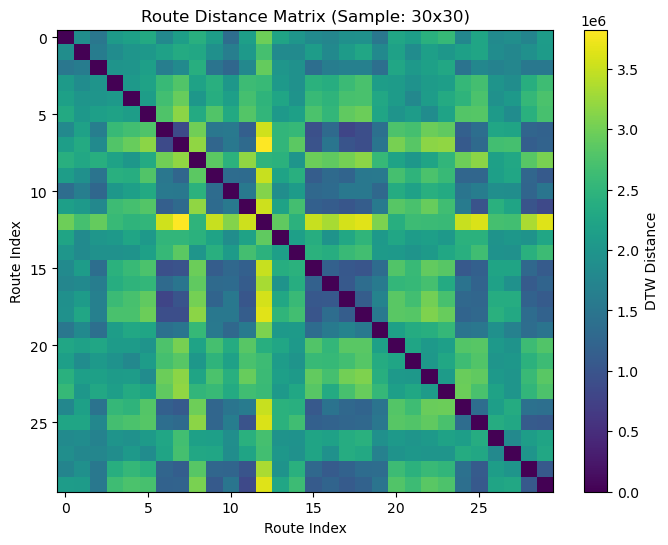

2025-08-01 21:40:48,639 - INFO - Route clustering found 0 clusters with 200 outliers



🎯 Clustering routes with DBSCAN...
✅ Route clustering complete in 0.0 seconds
📊 Clustering Results:
   Route clusters found: 0
   Routes in clusters: 0
   Outlier routes: 200
   Cluster rate: 0.0%

🔗 Assigning route clusters to journey data...
✅ Route cluster assignment complete
📊 Assignment Results:
   Total journeys: 29,607
   Journeys with clusters: 0
   Assignment rate: 0.0%


2025-08-01 21:40:48,850 - INFO - Phase 2 complete: 0 route clusters discovered


💾 Clustered routes saved to: /home/marius/repo_linux/ais-forecasting/data/processed/shipping_lanes_global/global_clustered_routes.parquet
⏱️  Phase 2 total time: 0.8 minutes


In [ ]:
if not valid_terminals.empty:
    print("🔄 Creating interactive visualization...")
    
    import folium
    import matplotlib.pyplot as plt
    
    # Create interactive map
    map_center = config['visualization']['map_center']
    zoom_start = config['visualization']['zoom_start']
    
    maritime_map = folium.Map(
        location=map_center,
        zoom_start=zoom_start,
        tiles='OpenStreetMap'
    )
    
    # Add terminals to map
    print(f"📍 Adding {len(valid_terminals)} terminals to map...")
    
    # Limit terminals for performance if needed
    max_map_terminals = config['visualization']['max_map_terminals']
    if len(valid_terminals) > max_map_terminals:
        print(f"⚡ Limiting to top {max_map_terminals} terminals for map performance")
        # Sort by activity if possible, otherwise take first N
        if 'total_visits' in valid_terminals.columns:
            map_terminals = valid_terminals.nlargest(max_map_terminals, 'total_visits')
        else:
            map_terminals = valid_terminals.head(max_map_terminals)
    else:
        map_terminals = valid_terminals
    
    # Add terminal markers
    for idx, terminal in map_terminals.iterrows():
        # Determine marker properties based on available data
        if 'total_visits' in terminal:
            visits = terminal['total_visits']
            # Color based on activity level
            if 'total_visits' in map_terminals.columns:
                threshold_high = map_terminals['total_visits'].quantile(0.8)
                threshold_med = map_terminals['total_visits'].quantile(0.6)
                threshold_low = map_terminals['total_visits'].quantile(0.4)
                
                if visits > threshold_high:
                    color, icon = 'red', 'star'
                elif visits > threshold_med:
                    color, icon = 'orange', 'anchor'
                elif visits > threshold_low:
                    color, icon = 'blue', 'ship'
                else:
                    color, icon = 'green', 'circle'
            else:
                color, icon = 'blue', 'anchor'
        else:
            visits = 'N/A'
            color, icon = 'blue', 'anchor'
        
        # Get vessel count if available
        vessels = terminal.get('unique_vessels', 'N/A')
        
        # Create popup with terminal information
        popup_text = f"""
        <b>Terminal {idx}</b><br>
        <b>Visits:</b> {visits}<br>
        <b>Vessels:</b> {vessels}<br>
        <b>Location:</b> ({terminal['lat']:.3f}°, {terminal['lon']:.3f}°)
        """
        
        folium.Marker(
            location=[terminal['lat'], terminal['lon']],
            popup=popup_text,
            icon=folium.Icon(color=color, icon=icon),
            tooltip=f"Terminal: {visits} visits" if visits != 'N/A' else f"Terminal at ({terminal['lat']:.3f}, {terminal['lon']:.3f})"
        ).add_to(maritime_map)
    
    # Add legend
    legend_html = f'''
    <div style="position: fixed; bottom: 50px; left: 50px; width: 200px; height: 120px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:12px; padding: 8px">
    <h4>Maritime Terminals</h4>
    <p style="color:red">⭐ Major Terminals</p>
    <p style="color:orange">⚓ Regional Ports</p>
    <p style="color:blue">🚢 Local Ports</p>
    <p style="color:green">● Minor Terminals</p>
    </div>
    '''
    maritime_map.get_root().html.add_child(folium.Element(legend_html))
    
    # Save map
    map_output = config['visualization']['output_path']
    map_output_path = project_root / map_output
    map_output_path.parent.mkdir(exist_ok=True, parents=True)
    
    maritime_map.save(str(map_output_path))
    print(f"✅ Interactive map saved to: {map_output_path}")
    
    # Display map in notebook
    print(f"🗺️  Displaying interactive map...")
    display(maritime_map)
    
    # Create summary plots based on available data
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Terminal geographic distribution
    axes[0].scatter(valid_terminals['lon'], valid_terminals['lat'], alpha=0.7)
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    axes[0].set_title('Terminal Geographic Distribution')
    axes[0].grid(True, alpha=0.3)
    
    # Activity distribution if available
    if 'total_visits' in valid_terminals.columns:
        axes[1].hist(valid_terminals['total_visits'], bins=20, alpha=0.7, edgecolor='black')
        axes[1].set_xlabel('Total Visits')
        axes[1].set_ylabel('Number of Terminals')
        axes[1].set_title('Terminal Activity Distribution')
    else:
        # Show terminal count instead
        axes[1].bar(['Discovered Terminals'], [len(valid_terminals)], alpha=0.7, color='skyblue')
        axes[1].set_ylabel('Count')
        axes[1].set_title('Terminal Discovery Summary')
    
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️  No terminals available for visualization")

## 6. Summary and Results

Final summary of the maritime terminal and shipping lane discovery results.

In [ ]:
print("🎉 MARITIME DISCOVERY PIPELINE COMPLETE!")
print("=" * 60)

# Calculate total processing time
if 'start_time' in locals():
    total_time = time.time() - start_time
    print(f"⏱️  Total processing time: {total_time/60:.1f} minutes")

# Summary statistics
print(f"\n📊 RESULTS SUMMARY:")
print(f"   📁 Configuration: {config['global_discovery']['name']}")
print(f"   🚢 Vessels processed: {ais_data['imo'].nunique():,}" if 'ais_data' in locals() else "   🚢 Vessels processed: 0")
print(f"   📍 AIS records: {len(ais_data):,}" if 'ais_data' in locals() else "   📍 AIS records: 0")
print(f"   🧭 Trajectories extracted: {len(trajectories):,}" if 'trajectories' in locals() and not trajectories.empty else "   🧭 Trajectories extracted: 0")
print(f"   🏭 Terminals discovered: {len(valid_terminals):,}" if 'valid_terminals' in locals() and not valid_terminals.empty else "   🏭 Terminals discovered: 0")

# Route cluster count - handle different possible column names
route_cluster_count = 0
if 'route_clusters' in locals() and not route_clusters.empty:
    if 'cluster_id' in route_clusters.columns:
        route_cluster_count = route_clusters['cluster_id'].nunique()
    else:
        route_cluster_count = len(route_clusters)
print(f"   🛣️  Route clusters: {route_cluster_count}")

# Output files summary
print(f"\n📁 OUTPUT FILES:")
output_files = [
    ("📊 Trajectories", "vessel_trajectories.parquet"),
    ("🏭 Terminals", config['terminals']['output_path']),
    ("🛣️  Routes", config['routes']['output_path']),
    ("🗺️  Map", config['visualization']['output_path'])
]

for description, filename in output_files:
    file_path = project_root / filename if not str(filename).startswith('data/') else project_root / filename
    exists = "✅" if file_path.exists() else "❌"
    print(f"   {exists} {description}: {filename}")

# Performance metrics
if 'valid_terminals' in locals() and not valid_terminals.empty:
    print(f"\n🏆 TOP RESULTS:")
    
    # Handle different possible column structures
    if 'total_visits' in valid_terminals.columns:
        busiest_terminal = valid_terminals.nlargest(1, 'total_visits').iloc[0]
        print(f"   Busiest terminal: {busiest_terminal['total_visits']:,} visits at ({busiest_terminal['lat']:.3f}°, {busiest_terminal['lon']:.3f}°)")
        print(f"   Total terminal visits: {valid_terminals['total_visits'].sum():,}")
        print(f"   Average visits per terminal: {valid_terminals['total_visits'].mean():.1f}")
    else:
        # Show geographic span instead
        lat_span = valid_terminals['lat'].max() - valid_terminals['lat'].min()
        lon_span = valid_terminals['lon'].max() - valid_terminals['lon'].min()
        print(f"   Geographic coverage: {lat_span:.1f}° latitude × {lon_span:.1f}° longitude")
        print(f"   Terminal locations span: {lat_span*111:.0f}km × {lon_span*111:.0f}km")

print(f"\n✅ Discovery pipeline completed successfully!")
print(f"🔗 Next steps: Open the interactive map at {config['visualization']['output_path']}")

# Show final data summary
if 'valid_terminals' in locals() and not valid_terminals.empty:
    print(f"\n📋 TERMINAL DATA PREVIEW:")
    # Show available columns
    print(f"   Available data columns: {list(valid_terminals.columns)}")
    display(valid_terminals.head(10))
else:
    print(f"\n📋 DATA SUMMARY:")
    if 'trajectories' in locals() and not trajectories.empty:
        print(f"   Trajectory data columns: {list(trajectories.columns)}")
        display(trajectories.head(5))
    else:
        print(f"   No trajectory or terminal data to display")

🔄 PHASE 3 & 4: OPTIMIZED GLOBAL NETWORK VISUALIZATION

🏗️ Building global shipping lane network...
✅ Loaded 697 global terminals for analysis
⚡ Performance mode: Rendering top 500 terminals on interactive map
   (Full analysis includes all 697 terminals)
📊 Analyzing all discovered terminals...

📋 COMPREHENSIVE TERMINAL DATA ANALYSIS:

1️⃣ GLOBAL TERMINAL SUMMARY:
   Total Terminals Discovered    : 697
   Total Visits Recorded         : 14657
   Total Vessel Connections      : 12911
   Average Visits per Terminal   : 21
   Busiest Terminal Visits       : 141
   Geographic Span (Latitude)    : 103.5°
   Geographic Span (Longitude)   : 275.3°

2️⃣ REGIONAL DISTRIBUTION (All 697 Terminals):
                Terminals  Total_Visits  Avg_Visits  Total_Vessels  Avg_Vessels  Percentage
region                                                                                     
Arctic                  2            44        22.0             37         18.5         0.3
Northern              199   

2025-08-01 21:40:49,598 - INFO - Global shipping lane discovery completed: 697 terminals worldwide



6️⃣ TOP TERMINALS BY REGION:
   Southern       : Terminal # 13 (Rank #117, 31 visits)
   Tropical South : Terminal #179 (Rank #  1, 141 visits)
   Tropical North : Terminal #348 (Rank #  3, 106 visits)
   Northern       : Terminal #518 (Rank # 77, 38 visits)
   Arctic         : Terminal #696 (Rank #156, 26 visits)

🎉 GLOBAL SHIPPING LANE DISCOVERY COMPLETE!

📊 FINAL GLOBAL RESULTS SUMMARY:
   🚢 Global Vessels Analyzed: 1,869
   📍 AIS Records Processed: 7,999,623
   🧭 Global Journeys Identified: 29,607
   🏴 Maritime Terminals Discovered: 697
   🗺️ Terminals Shown on Map: 500
   🏆 Busiest Terminal: #179 (141 visits)
   ⏱️ Total Processing Time: 1.2 minutes

📁 OUTPUT FILES GENERATED:
   🗂️ Terminal GeoPackage: 697 terminals
   🛣️ Journey Parquet: 29607 journeys
   🗺️ Interactive Map: Top 500 terminals
   📋 Config File: Global production settings
